In [74]:
import os
from pymongo import MongoClient
import pandas as pd
from collections import Counter

In [29]:
MONGO_URI = os.getenv("MONGO_URI")
DB_NAME = os.getenv("MONGO_DB_NAME")
COLLECTION_NAME = os.getenv("NER_LABELED_COLLECTION")

client = MongoClient(MONGO_URI)
col = client[DB_NAME][COLLECTION_NAME]


# Phân tích ở mức document

In [30]:

# Lấy full documents (bỏ _id cho gọn)
docs = list(col.find({}, {"_id": 0}))
client.close()

print("Total docs:", len(docs))

Total docs: 1182


In [18]:
# --- Label Studio: text thường nằm trong doc["data"][<field>] ---
def get_text_field(doc):
    data = doc.get("data", {})
    for k in ("text", "content", "sentence", "input", "review"):
        if k in data and isinstance(data[k], str):
            return data[k]
    # fallback: lấy string đầu tiên trong data
    for k, v in data.items():
        if isinstance(v, str):
            return v
    return None

rows = []
for d in docs:
    t = get_text_field(d)
    if t is not None:
        rows.append({
            "id": d.get("id"),
            "text": t,
        })


In [20]:
df = pd.DataFrame(rows)
print("Docs with text:", len(df))

df.head()

Docs with text: 1182


,id,text
0,45897,"Vitamin C có tên khoa học là Acid Ascorbic, đư..."
1,45898,"Theo nghiên cứu,chúng thuộc dạng Vitamin tan đ..."
2,45899,Không chỉ là hoạt chất hỗ trợ tăng cường sức đ...
3,45900,"Ngoài ra,Vitamin C cũng góp phần tăng sinh sợi..."
4,45901,Thành phầm Tranexamic acid là một thành phần t...


In [21]:
df["text_len"] = df["text"].str.len()
df["text_len"].describe()


count    1182.000000
mean      128.351100
std        72.293323
min        22.000000
25%        88.000000
50%       111.000000
75%       156.000000
max      1135.000000
Name: text_len, dtype: float64

**Nhận xét phân bố độ dài văn bản (Text Length)**

- Dataset gồm 1.182 mẫu câu.
- Độ dài trung bình khoảng 128 ký tự, với độ lệch chuẩn ~72, cho thấy độ dài các câu khá phân tán.
- 50% mẫu nằm trong khoảng 88–156 ký tự (IQR).

In [23]:
import re

def count_tokens(text):
    return len(re.findall(r"\w+", text))

df["token_len"] = df["text"].apply(count_tokens)
df["token_len"].describe()


count    1182.000000
mean       28.045685
std        16.401233
min         5.000000
25%        19.000000
50%        24.000000
75%        34.000000
max       251.000000
Name: token_len, dtype: float64

**Nhận xét phân bố độ dài câu theo token (Token Length)**
- Số token trung bình khoảng 28 token/câu, với độ lệch chuẩn ~16, cho thấy độ dài câu tương đối ổn định.
- 50% câu có ≤ 24 token, và 75% câu có ≤ 34 token → đa số câu ngắn, rõ nghĩa, phù hợp cho NER

# Phân tích sau khi đã NER

In [ ]:
def extract_entities_from_docs(docs):
    rows = []

    for doc in docs:
        source_id = doc.get("source_id")
        ls_id = doc.get("id")
        text = (doc.get("data") or {}).get("text", "")

        annotations = doc.get("annotations") or []
        for ann_idx, ann in enumerate(annotations):
            results = ann.get("result") or ann.get("results") or []

            for res_idx, r in enumerate(results):
                if r.get("type") not in ("labels", "label"):
                    continue

                val = r.get("value") or {}
                start = val.get("start")
                end = val.get("end")
                ent_text = val.get("text")
                labels = val.get("labels") or []

                if not labels:
                    continue

                label = labels[0]

                # fallback nếu thiếu text
                if ent_text is None and isinstance(start, int) and isinstance(end, int):
                    ent_text = text[start:end]

                rows.append({
                    "source_id": source_id,
                    "ls_id": ls_id,
                    "label": label,
                    "start": start,
                    "end": end,
                    "entity_text": ent_text,
                })

    return pd.DataFrame(rows)


In [25]:
df_entity = extract_entities_from_docs(docs)


In [27]:
print("Total entities:", len(df_entity))
df_entity.head(10)

Total entities: 4037


,source_id,ls_id,label,start,end,entity_text
0,a0ce7a13-2149-40c1-98e8-a56bfda533a1,45897,NAME,0,9,Vitamin C
1,a0ce7a13-2149-40c1-98e8-a56bfda533a1,45897,INCI,29,42,Acid Ascorbic
2,e307c904-c97e-42cf-8975-0ae357e02a8a,45898,NAME,201,210,Vitamin C
3,e307c904-c97e-42cf-8975-0ae357e02a8a,45898,BENEFITS,147,184,"giúp duy trì làn da sáng khỏe,rạng rỡ"
4,e307c904-c97e-42cf-8975-0ae357e02a8a,45898,ORIGIN,232,263,trong thực vật(rau củ quả tươi)
5,e307c904-c97e-42cf-8975-0ae357e02a8a,45898,NAME,264,273,Vitamin C
6,e307c904-c97e-42cf-8975-0ae357e02a8a,45898,NAME,378,387,Vitamin C
7,e307c904-c97e-42cf-8975-0ae357e02a8a,45898,ORIGIN,304,325,trong rau củ quả tươi
8,e307c904-c97e-42cf-8975-0ae357e02a8a,45898,NAME,130,139,vitamin c
9,7d33eaae-8be6-49e0-b792-57a38b994b58,45899,NAME,186,196,"Vitamin C,"


In [35]:
df_stats = pd.concat(
    [
        df_entity["label"].value_counts(),
        (df_entity["label"].value_counts(normalize=True) * 100).round(2)
    ],
    axis=1,
    keys=["count", "percent"]
)

df_stats

,count,percent
label,,
BENEFITS,1622,40.18
NAME,1109,27.47
SKIN_CONCERNS,590,14.61
INCI,370,9.17
ORIGIN,346,8.57


Dataset gồm 5 loại thực thể, tổng số thực thể trong dataset là 4037. Tỉ lệ giữa entity xuất hiện nhiều nhất (BENEFITS) và ít nhất (ORIGIN) xấp xỉ 4.7 : 1 thể hiện sự mất cân bằng không quá nghiêm trọng. BENEFITS và NAME có tần suất xuất hiện cao nhất, INCI và ORIGIN có tần suất xuất hiện thấp nên có nguy cơ bị mô hình bỏ sót khi huấn luyện.

# Phân tích sau RE

In [40]:
MONGO_URI = os.getenv("MONGO_URI")
DB_NAME = os.getenv("MONGO_DB_NAME")
COLLECTION_NAME = os.getenv("RE_LABELED_COLLECTION")

client = MongoClient(MONGO_URI)
col = client[DB_NAME][COLLECTION_NAME]

In [ ]:
relations = []

for doc in col.find({}, {"annotations": 1, "id": 1}):
    for ann in doc.get("annotations", []):
        for r in ann.get("result", []):
            if r.get("type") == "relation":
                relations.append({
                    "task_id": doc.get("id"),
                    "annotation_id": ann.get("id"),
                    "from_id": r.get("from_id"),
                    "to_id": r.get("to_id"),
                    "direction": r.get("direction"),
                    "labels": r.get("labels")
                })

print(f"Total relations: {len(relations)}")

Total relations: 2690


In [79]:
labels = [
    r["labels"][0] for r in relations
    if r.get("labels") and len(r["labels"]) > 0
]

label_cnt = Counter(labels)

df_label = (
    pd.DataFrame(label_cnt.items(), columns=["relation_label", "count"])
      .sort_values("count", ascending=False)
)

df_label['percent'] = (df_label["count"] / df_label["count"].sum() * 100).round(2)
df_label

,relation_label,count,percent
1,has_benefits,1586,59.18
3,targets_skin_concerns,565,21.08
2,has_origin,346,12.91
0,has_inci_name,183,6.83


**Nhận xét phân bố relation trong bộ dữ liệu**
- Dataset bị mất cân bằng khá rõ.
- `has_benefits` chiếm ~59%, là label chủ đạo.
- `targets_skin_concerns` (~21%) và `has_origin` (~13%) có lượng dữ liệu ở mức trung bình.
- `has_inci_name` là label ít nhất (~7%), có nguy cơ recall thấp khi train.

In [66]:
entity_map = {}  # key: (task_id, annotation_id, entity_id)

doc_text_map = {}  # task_id -> text

for doc in col.find({}, {"annotations": 1, "id": 1, "data.text": 1}):
    task_id = doc.get("id")
    doc_text_map[task_id] = (doc.get("data") or {}).get("text", "")

    for ann in doc.get("annotations", []):
        ann_id = ann.get("id")
        for r in ann.get("result", []):
            if r.get("type") == "labels":
                entity_map[(task_id, ann_id, r["id"])] = {
                    "text": r["value"]["text"],
                    "start": r["value"]["start"],
                    "end": r["value"]["end"],
                    "label": r["value"]["labels"][0] if r["value"]["labels"] else None
                }


In [69]:
rows = []

for rel in relations:
    key1 = (rel["task_id"], rel["annotation_id"], rel["from_id"])
    key2 = (rel["task_id"], rel["annotation_id"], rel["to_id"])

    if key1 not in entity_map or key2 not in entity_map:
        continue

    e1 = entity_map[key1]
    e2 = entity_map[key2]

    # distance theo character
    if e1["start"] <= e2["start"]:
        dist = e2["start"] - e1["end"]
    else:
        dist = e1["start"] - e2["end"]

    rows.append({
        "task_id": rel["task_id"],
        "label": rel["labels"][0] if rel["labels"] else None,
        "distance": dist
    })

df_dist = pd.DataFrame(rows)
df_dist["distance"].describe()


count    2690.000000
mean       51.995539
std        47.778402
min        -7.000000
25%        17.000000
50%        42.000000
75%        71.000000
max       663.000000
Name: distance, dtype: float64

<Axes: title={'center': 'Entity-pair distance distribution'}, ylabel='Frequency'>

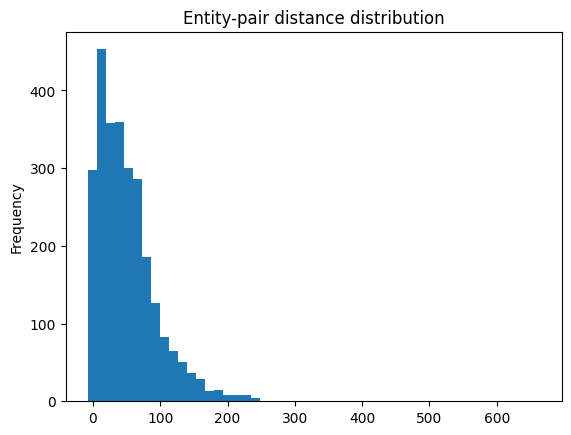

In [ ]:
df_dist["distance"].plot.hist(bins=50, title="Entity-pair distance distribution")

- Phần lớn relation có distance < 100
- Đỉnh tập trung mạnh trong khoảng 10–50 ký tự

→ đa số entity nằm gần nhau trong cùng mệnh đề / câu

In [80]:
rel_count_per_doc = Counter([r["task_id"] for r in relations])

df_multi = pd.DataFrame([
    {"task_id": k, "num_relations": v}
    for k, v in rel_count_per_doc.items()
])

total_docs = len(df_multi)
multi_docs = (df_multi["num_relations"] > 1).sum()

print("Total docs with relations:", total_docs)
print("Docs with >1 relation:", multi_docs)
print("Ratio multi-relation:", multi_docs / total_docs)


Total docs with relations: 937
Docs with >1 relation: 725
Ratio multi-relation: 0.7737459978655283


In [84]:
df_multi.num_relations.value_counts().sort_index()

num_relations
1     212
2     270
3     211
4     122
5      33
6      52
7       6
8      17
9       1
10      5
12      4
13      1
14      3
Name: count, dtype: int64

**Nhận xét phân bố số relation trên mỗi document**
- Có 937 document chứa relation, trong đó 77.4% là đa quan hệ (>1 relation).
- Phổ biến nhất là 2–3 relations/doc (chiếm đa số).
- Chỉ 212 doc (~23%) có đúng 1 relation.